In [1]:
import sqlite3
db = sqlite3.connect("./data_gatherer/fintime.db",check_same_thread=False)

In [2]:
cursor = db.cursor()
cursor.execute("SELECT ticker,dataJSON FROM stockData")
stockData = cursor.fetchall()

In [ ]:
import json
company_descriptions = {}

with open("./data_gatherer/company_descriptions.json") as f:
    company_descriptions = json.load(f)

In [3]:
import json
data = []
for row in stockData:
    dataaa = json.loads(row[1])
    dataaa['ticker'] = row[0]
    data.append(dataaa)

In [4]:
from datetime import datetime
def getDataForDaysHistorical(hist, daysStart, daysEnd):
    midPoint = int(len(hist) / 2)
    startIndex = midPoint + daysStart
    endIndex = midPoint + daysEnd
    data = hist[startIndex:endIndex]
    return data, hist[midPoint]

def getDaysFrumCurrentD(hist):
    midPoint = int(len(hist) / 2)

    return hist[midPoint]["Date"]

def getDaysFrumCurrent(hist):
        date_str = getDaysFrumCurrentD(hist)
        date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        current_date = datetime.now()
        difference = (current_date - date_obj).days
        return difference


def getLowestLow(hist):
    lowest = hist[0]["Low"]
    for day in hist:
        if day["Low"] < lowest:
            lowest = day["Low"]
    return lowest
def getDividends(hist):
    dividends = 0
    for day in hist:
        if day["Dividends"] != 0:
            dividends += day["Dividends"]
    return dividends
def getHighestHigh(hist):
    highest = hist[0]["High"]
    for day in hist:
        if day["High"] > highest:
            highest = day["High"]
    return highest


def getLowAndHighForDays(hist, start, end):
    newHist,midpoint = getDataForDaysHistorical(hist, start, end)
    return getLowestLow(newHist), getHighestHigh(newHist),getDividends(newHist),midpoint["Date"]

def getDataForPercentageRange(hist, startPercent, endPercent):
    midPoint = len(hist) // 2
    startIndex = midPoint + int(midPoint * startPercent / 100)
    endIndex = midPoint + int(midPoint * endPercent / 100)
    startIndex = max(0, startIndex)
    endIndex = min(len(hist), endIndex)
    data = hist[startIndex:endIndex]
    return getHighestHigh(data), getLowestLow(data), getDividends(data)

print(getDaysFrumCurrent(data[0]["hist"]))

179


In [ ]:
getDataForPercentageRange(data[0]["hist"],-50,-20)

In [5]:
err=0
for dataP in data:
        try:
            getDataForPercentageRange(dataP["hist"], -100, -80)[0]
            getDataForPercentageRange(dataP["hist"], -80, -60)[1]
            getDataForPercentageRange(dataP["hist"], -60, -40)[0]
            getDataForPercentageRange(dataP["hist"], -60, -40)[1]
            getDataForPercentageRange(dataP["hist"], -40, -20)[0]
            getDataForPercentageRange(dataP["hist"], -40, -20)[1]
            getDataForPercentageRange(dataP["hist"], -20, -0)[0]
            getDataForPercentageRange(dataP["hist"], -20, -0)[1]

            getDataForPercentageRange(dataP["hist"], 0, 20)
            getDataForPercentageRange(dataP["hist"], 0, 100)
        except:
              err+=1
              data.remove(dataP)
err

6

In [6]:
newData=[]
results = []
for company in data:
        result = []
        extra = company.get("extra", {})
        
        # Extract numeric features from 'extra' section
        fiscal_year = extra.get("Fiscal Year", {})
        profitability = extra.get("Profitability", {})
        management = extra.get("Management Effectiveness", {})
        income_statement = extra.get("Income Statement", {})
        balance_sheet = extra.get("Balance Sheet", {})
        cash_flow = extra.get("Cash Flow Statement", {})
        stock_history = extra.get("Stock Price History", {})
        share_stats = extra.get("Share Statistics", {})
        dividends_splits = extra.get("Dividends & Splits", {})
        
        result = [
            company.get("current_price", 0) or -1,
            company.get("Market Cap", 0) or -1,
            company.get("Enterprise Value", 0) or -1,
            company.get("Trailing P/E", 0) or -1,
            company.get("Forward P/E", 0) or -1,
            company.get("PEG Ratio (5yr expected)", 0) or -1,
            company.get("Price/Sales", 0) or -1,
            company.get("Price/Book", 0) or -1,
            company.get("Enterprise Value/Revenue", 0) or -1,
            company.get("Enterprise Value/EBITDA", 0) or -1,
            getDataForPercentageRange(company.get("hist"), -100, -80)[0],
            getDataForPercentageRange(company.get("hist"), -80, -60)[1],
            getDataForPercentageRange(company.get("hist"), -60, -40)[0],
            getDataForPercentageRange(company.get("hist"), -60, -40)[1],
            getDataForPercentageRange(company.get("hist"), -40, -20)[0],
            getDataForPercentageRange(company.get("hist"), -40, -20)[1],
            getDataForPercentageRange(company.get("hist"), -20, -0)[0],
            getDataForPercentageRange(company.get("hist"), -20, -0)[1],

            float(profitability.get("Profit Margin", -1)) if profitability.get("Profit Margin") is not None else -1.0,
            float(profitability.get("Operating Margin  (ttm)", -1)) if profitability.get("Operating Margin  (ttm)") is not None else -1.0,
            # Management Effectiveness
            float(management.get("Return on Assets  (ttm)", -1)) if management.get("Return on Assets  (ttm)") is not None else -1.0,
            float(management.get("Return on Equity  (ttm)", -1)) if management.get("Return on Equity  (ttm)") is not None else -1.0,
            # Income Statement
            float(income_statement.get("Revenue  (ttm)", 0)) if income_statement.get("Revenue  (ttm)") is not None else -1.0,
            float(income_statement.get("Revenue Per Share  (ttm)", 0)) if income_statement.get("Revenue Per Share  (ttm)") is not None else -1.0,
            float(income_statement.get("Quarterly Revenue Growth  (yoy)", 0)) if income_statement.get("Quarterly Revenue Growth  (yoy)") is not None else -1.0,
            float(income_statement.get("Gross Profit  (ttm)", 0)) if income_statement.get("Gross Profit  (ttm)") is not None else -1.0,
            float(income_statement.get("EBITDA", 0)) if income_statement.get("EBITDA") is not None else -1.0,
            float(income_statement.get("Net Income Avi to Common  (ttm)", 0)) if income_statement.get("Net Income Avi to Common  (ttm)") is not None else -1.0,
            float(income_statement.get("Diluted EPS  (ttm)", 0)) if income_statement.get("Diluted EPS  (ttm)") is not None else -1.0,
            float(income_statement.get("Quarterly Earnings Growth  (yoy)", 0)) if income_statement.get("Quarterly Earnings Growth  (yoy)") is not None else -1.0,
            # Balance Sheet
            float(balance_sheet.get("Total Cash  (mrq)", 0)) if balance_sheet.get("Total Cash  (mrq)") is not None else -1.0,
            float(balance_sheet.get("Total Cash Per Share  (mrq)", 0)) if balance_sheet.get("Total Cash Per Share  (mrq)") is not None else -1.0,
            float(balance_sheet.get("Total Debt  (mrq)", 0)) if balance_sheet.get("Total Debt  (mrq)") is not None else -1.0,
            float(balance_sheet.get("Total Debt/Equity  (mrq)", 0)) if balance_sheet.get("Total Debt/Equity  (mrq)") is not None else -1.0,
            float(balance_sheet.get("Current Ratio  (mrq)", 0)) if balance_sheet.get("Current Ratio  (mrq)") is not None else -1.0,
            float(balance_sheet.get("Book Value Per Share  (mrq)", 0)) if balance_sheet.get("Book Value Per Share  (mrq)") is not None else -1.0,
            # Cash Flow Statement
            float(cash_flow.get("Operating Cash Flow  (ttm)", 0)) if cash_flow.get("Operating Cash Flow  (ttm)") is not None else -1.0,
            float(cash_flow.get("Levered Free Cash Flow  (ttm)", 0)) if cash_flow.get("Levered Free Cash Flow  (ttm)") is not None else -1.0,
            # Stock Price History
            float(stock_history.get("Beta (5Y Monthly)", 0)) if stock_history.get("Beta (5Y Monthly)") is not None else -1.0,
            float(stock_history.get("52 Week Range3", 0)) if stock_history.get("52 Week Range3") is not None else -1.0,
            float(stock_history.get("S&P 500 52-Week Change3", 0)) if stock_history.get("S&P 500 52-Week Change3") is not None else -1.0,
            float(stock_history.get("52 Week High3", 0)) if stock_history.get("52 Week High3") is not None else -1.0,
            float(stock_history.get("52 Week Low3", 0)) if stock_history.get("52 Week Low3") is not None else -1.0,
            float(stock_history.get("50-Day Moving Average3", 0)) if stock_history.get("50-Day Moving Average3") is not None else -1.0,
            float(stock_history.get("200-Day Moving Average3", 0)) if stock_history.get("200-Day Moving Average3") is not None else -1.0,
            # Share Statistics
            float(share_stats.get("Avg Vol (3 month)3", 0)) if share_stats.get("Avg Vol (3 month)3") is not None else -1.0,
            float(share_stats.get("Avg Vol (10 day)3", 0)) if share_stats.get("Avg Vol (10 day)3") is not None else -1.0,
            float(share_stats.get("Shares Outstanding5", 0)) if share_stats.get("Shares Outstanding5") is not None else -1.0,
            float(share_stats.get("Implied Shares Outstanding6", 0)) if share_stats.get("Implied Shares Outstanding6") is not None else -1.0,
            float(share_stats.get("Float8", 0)) if share_stats.get("Float8") is not None else -1.0,
            float(share_stats.get("% Held by Insiders1", 0)) if share_stats.get("% Held by Insiders1") is not None else -1.0,
            float(share_stats.get("% Held by Institutions1", 0)) if share_stats.get("% Held by Institutions1") is not None else -1.0,
            float(share_stats.get("Shares Short (12/31/2024)4", 0)) if share_stats.get("Shares Short (12/31/2024)4") is not None else -1.0,
            float(share_stats.get("Short Ratio (12/31/2024)4", 0)) if share_stats.get("Short Ratio (12/31/2024)4") is not None else -1.0,
            float(share_stats.get("Short % of Float (12/31/2024)4", 0)) if share_stats.get("Short % of Float (12/31/2024)4") is not None else -1.0,
            float(share_stats.get("Short % of Shares Outstanding (12/31/2024)4", 0)) if share_stats.get("Short % of Shares Outstanding (12/31/2024)4") is not None else -1.0,
            float(share_stats.get("Shares Short (prior month 11/29/2024)4", 0)) if share_stats.get("Shares Short (prior month 11/29/2024)4") is not None else -1.0,
        ]
        for feature in result:
            if feature == -1:
                result.remove(feature)
        if len(result)>52:
            newData.append(company)
        results.append(len(result))
print(results[0:25])

[53, 40, 57, 53, 54, 40, 57, 53, 54, 40, 54, 57, 54, 40, 57, 54, 40, 57, 52, 54, 50, 53, 50, 53, 54]


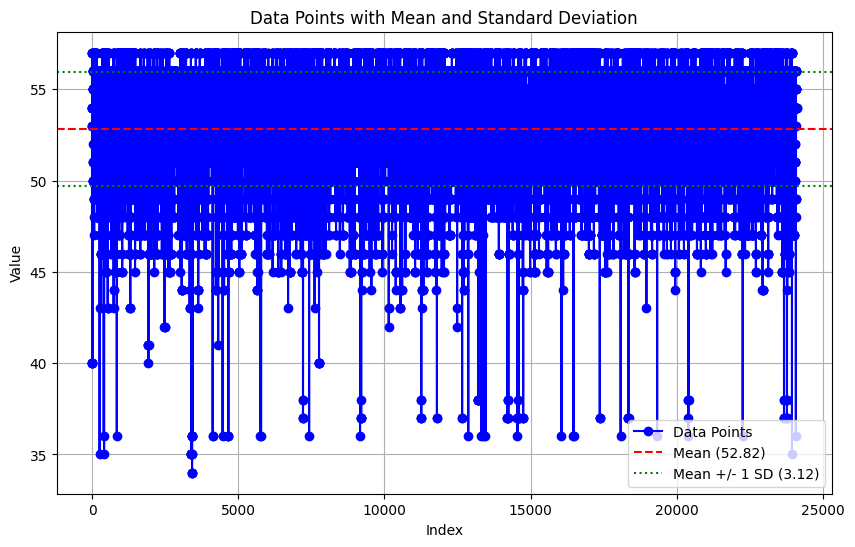

In [7]:
import matplotlib.pyplot as plt
import statistics


mean = statistics.mean(results)
std_dev = statistics.stdev(results)

plt.figure(figsize=(10, 6))
plt.plot(results, 'bo-', label='Data Points') 
plt.axhline(mean, color='r', linestyle='--', label=f'Mean ({mean:.2f})')
plt.axhline(mean + std_dev, color='g', linestyle=':', label=f'Mean +/- 1 SD ({std_dev:.2f})')
plt.axhline(mean - std_dev, color='g', linestyle=':')

plt.title('Data Points with Mean and Standard Deviation')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
data = newData

In [9]:
import random
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

data = [company for company in data if 'hist' in company and company['hist'] is not None]
random.shuffle(data)


test_size = int(len(data) * 0.20)
test_data = data[:test_size]
train_data = data[test_size:]


numeric_imputer = SimpleImputer(strategy='median')
robust_scaler = RobustScaler()

text_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=500,
            lowercase=True,
            ngram_range=(1, 2)
        )),
        ('svd', TruncatedSVD(n_components=100, random_state=42))
    ])

#Feature Engineering
def get_features(company):
    import numpy as np
    features = []
    
    extra = company.get('extra', {})
    profitability = extra.get('Profitability', {})
    management = extra.get('Management Effectiveness', {})
    income_statement = extra.get("Income Statement", {})
    balance_sheet = extra.get("Balance Sheet", {})
    cash_flow = extra.get("Cash Flow Statement", {})
    stock_history = extra.get("Stock Price History", {})
    share_stats = extra.get("Share Statistics", {})
    
    features.append(company.get('current_price', 0) or np.nan)
    features.append(company.get('Market Cap', 0) or np.nan)
    features.append(company.get('Enterprise Value', 0) or np.nan)
    features.append(company.get("Trailing P/E", 0) or np.nan)
    features.append(company.get("Forward P/E", 0) or np.nan)
    features.append(company.get("PEG Ratio (5yr expected)", 0) or np.nan)
    features.append(company.get("Price/Sales", 0) or np.nan)
    features.append(company.get("Price/Book", 0) or np.nan)
    features.append(company.get("Enterprise Value/Revenue", 0) or np.nan)
    features.append(company.get("Enterprise Value/EBITDA", 0) or np.nan)
    
    # Getting history base pecentage changes with percentage ranges
    val = getDataForPercentageRange(company.get("hist"), -100, -80)
    features.append(val[0] if val else np.nan)
    features.append(val[1] if val and len(val) > 1 else np.nan)
    val = getDataForPercentageRange(company.get("hist"), -60, -40)
    features.append(val[0] if val else np.nan)
    features.append(val[1] if val and len(val) > 1 else np.nan)
    val = getDataForPercentageRange(company.get("hist"), -40, -20)
    features.append(val[0] if val else np.nan)
    features.append(val[1] if val and len(val) > 1 else np.nan)
    val = getDataForPercentageRange(company.get("hist"), -20, 0)
    features.append(val[0] if val else np.nan)
    features.append(val[1] if val and len(val) > 1 else np.nan)
    
    features.append(float(profitability.get("Profit Margin", 0) or np.nan))
    features.append(float(profitability.get("Operating Margin  (ttm)", 0) or np.nan))
    
    features.append(float(management.get("Return on Assets  (ttm)", 0) or np.nan))
    features.append(float(management.get("Return on Equity  (ttm)", 0) or np.nan))
    
    features.append(float(income_statement.get("Revenue  (ttm)", 0) or np.nan))
    features.append(float(income_statement.get("Revenue Per Share  (ttm)", 0) or np.nan))
    features.append(float(income_statement.get("Quarterly Revenue Growth  (yoy)", 0) or np.nan))
    features.append(float(income_statement.get("Gross Profit  (ttm)", 0) or np.nan))
    features.append(float(income_statement.get("EBITDA", 0) or np.nan))
    features.append(float(income_statement.get("Net Income Avi to Common  (ttm)", 0) or np.nan))
    features.append(float(income_statement.get("Diluted EPS  (ttm)", 0) or np.nan))
    features.append(float(income_statement.get("Quarterly Earnings Growth  (yoy)", 0) or np.nan))
    features.append(float(balance_sheet.get("Total Cash  (mrq)", 0) or np.nan))
    features.append(float(balance_sheet.get("Total Cash Per Share  (mrq)", 0) or np.nan))
    features.append(float(balance_sheet.get("Total Debt  (mrq)", 0) or np.nan))
    features.append(float(balance_sheet.get("Total Debt/Equity  (mrq)", 0) or np.nan))
    features.append(float(balance_sheet.get("Current Ratio  (mrq)", 0) or np.nan))
    features.append(float(balance_sheet.get("Book Value Per Share  (mrq)", 0) or np.nan))
    features.append(float(cash_flow.get("Operating Cash Flow  (ttm)", 0) or np.nan))
    features.append(float(cash_flow.get("Levered Free Cash Flow  (ttm)", 0) or np.nan))
    features.append(float(stock_history.get("Beta (5Y Monthly)", 0) or np.nan))
    features.append(float(stock_history.get("52 Week Range3", 0) or np.nan))
    features.append(float(stock_history.get("S&P 500 52-Week Change3", 0) or np.nan))
    features.append(float(stock_history.get("52 Week High3", 0) or np.nan))
    features.append(float(stock_history.get("52 Week Low3", 0) or np.nan))
    features.append(float(stock_history.get("50-Day Moving Average3", 0) or np.nan))
    features.append(float(stock_history.get("200-Day Moving Average3", 0) or np.nan))
    features.append(float(share_stats.get("Avg Vol (3 month)3", 0) or np.nan))
    features.append(float(share_stats.get("Avg Vol (10 day)3", 0) or np.nan))
    features.append(float(share_stats.get("Shares Outstanding5", 0) or np.nan))
    features.append(float(share_stats.get("Implied Shares Outstanding6", 0) or np.nan))
    features.append(float(share_stats.get("Float8", 0) or np.nan))
    features.append(float(share_stats.get("% Held by Insiders1", 0) or np.nan))
    features.append(float(share_stats.get("% Held by Institutions1", 0) or np.nan))
    features.append(float(share_stats.get("Shares Short (12/31/2024)4", 0) or np.nan))
    features.append(float(share_stats.get("Short Ratio (12/31/2024)4", 0) or np.nan))
    features.append(float(share_stats.get("Short % of Float (12/31/2024)4", 0) or np.nan))
    features.append(float(share_stats.get("Short % of Shares Outstanding (12/31/2024)4", 0) or np.nan))
    features.append(float(share_stats.get("Shares Short (prior month 11/29/2024)4", 0) or np.nan))
    
    return features

def get_targets(company):
    try:
        hist = company['hist']
        ranges = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100), (10, 100)]
        lowhigh = []
        for r_start, r_end in ranges:
            data = getDataForPercentageRange(hist, r_start, r_end)
            lowhigh.extend(data[0:2])
        if len(lowhigh) != 12 or any(np.isnan(lowhigh)):
            return None
        return lowhigh
    except Exception as e:
        print(f"Error processing targets: {str(e)}")
        return None
    
# Preprocessing data for training
def preprocess_data(data_subset, fit=False):
    X_numeric = []
    y = []
    descriptions = []
    
    for company in data_subset:
        features = get_features(company)
        X_numeric.append(features)

        targets = get_targets(company)
        if targets is None:
            continue
        y.append(targets)
        
        desc = str(company.get('company_description', '')).lower()
        descriptions.append(desc)
    
    if fit:
        X_numeric = numeric_imputer.fit_transform(X_numeric)
        X_numeric = robust_scaler.fit_transform(X_numeric)
        X_text = text_pipeline.fit_transform(descriptions)
    else:
        X_numeric = numeric_imputer.transform(X_numeric)
        X_numeric = robust_scaler.transform(X_numeric)
        X_text = text_pipeline.transform(descriptions)
    X = np.hstack([X_numeric, X_text])
    X = np.nan_to_num(X)
    
    return X, np.array(y)
def evaluate_model(model, X_test, y_test, scaler, name):
    y_pred = model.predict(X_test)
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test)
    
    # Flatten the arrays
    y_test_flat = y_test_original.ravel()
    y_pred_flat = y_pred_original.ravel()
    
    # Calculate metrics
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    r2 = r2_score(y_test_flat, y_pred_flat)
    
    print(f"\n{name} Performance:")
    print(f" MSE: {mse:.2f}")
    print(f" RMSE: {rmse:.2f}")
    print(f" MAE: {mae:.2f}")
    print(f" R2: {r2:.2f}")

In [11]:
import json
import numpy as np
import random
from sklearn.neural_network import MLPRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error

data = [company for company in data if 'hist' in company and company['hist'] is not None]
random.shuffle(data)

test_size = int(len(data) * 0.20)
test_data = data[:test_size]
train_data = data[test_size:]

text_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=500,
            lowercase=True,
            ngram_range=(1, 2)
        )),
        ('svd', TruncatedSVD(n_components=100, random_state=42))
    ])
robust_scaler = RobustScaler()

X_train, y_train = preprocess_data(train_data, fit=True)
X_test, y_test = preprocess_data(test_data, fit=False)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

In [ ]:


def build_nn_model():
    return MultiOutputRegressor(
        MLPRegressor(
            early_stopping=True,
            validation_fraction=0.2,
            random_state=42,
            max_iter=2000,
            solver='adam'
        )
    )

# Neural Network with Grid Search
nn_param_grid = {
    'estimator__hidden_layer_sizes': [(128,), (256, 128), (128, 64, 32)],
    'estimator__activation': ['relu', 'tanh'],
    'estimator__alpha': [0.0001, 0.001],
    'estimator__learning_rate_init': [0.001, 0.0001]
}
nn_param_grid_best = {
    'estimator__hidden_layer_sizes': [(256, 128)],
    'estimator__activation': ['tanh'],
    'estimator__alpha': [0.001],
    'estimator__learning_rate_init': [0.0001]
}

nn_grid = GridSearchCV(
    build_nn_model(),
    nn_param_grid_best,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
nn_grid.fit(X_train, y_train)
best_nn = nn_grid.best_estimator_

nn_metrics = evaluate_model(best_nn, X_test, y_test, y_scaler, "Neural Network")




Traceback (most recent call last):
  File "/Users/mihaialexandruilie/.pyenv/versions/3.9.2/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/mihaialexandruilie/.pyenv/versions/3.9.2/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/mihaialexandruilie/.pyenv/versions/3.9.2/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mihaialexandruilie/.pyenv/versions/3.9.2/lib/python3.9/runpy.py", line 188, in _run_module_as_main
  File "/Users/mihaialexandruilie/.pyenv/versions/3.9.2/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/mihaialexandruilie/.pyenv/versions/3.9.2/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/mihaialexandruilie/.pyenv/versions/3.9.2/lib/python3.9/r

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor


xgb_param_grid = {
    'estimator__n_estimators': [100, 500, 1000,1500],
    'estimator__learning_rate': [0.1,0.001,0.0001],
    'estimator__max_depth': [7,12,16],
    'estimator__subsample': [0.8, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0]
}

xgb_model = MultiOutputRegressor(XGBRegressor(random_state=42))
xgb_grid = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)

# Best model for evaluation
best_xgb_model = xgb_grid.best_estimator_
xgb_metrics = evaluate_model(best_xgb_model, X_test, y_test, y_scaler, "XGBoost")

print("Best XGBoost Parameters:", xgb_grid.best_params_)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

rf_param_grid = {
    'estimator__n_estimators': [100, 200, 300,500],
    'estimator__max_depth': [10, 15, 20,30,40,50],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['sqrt', 'log2']
}

# Random Forest model wrapped in MultiOutputRegressor
rf_model = MultiOutputRegressor(
    RandomForestRegressor(
        random_state=42,
        n_jobs=24,
        verbose=1
    )
)

rf_grid = GridSearchCV(
    rf_model,
    rf_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

best_rf_model = rf_grid.best_estimator_
print(evaluate_model(best_rf_model, X_test, y_test, y_scaler, "RF"))

print("Best Random Forest Parameters:", rf_grid.best_params_)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Assume X_train, X_test, y_train, y_test, and y_scaler are already defined
# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# Best Hyperparameters: {'lstm_units': 512, 'dropout_rate': 0.05, 'learning_rate': 0.001, 'batch_size': 128}
# Define hyperparameter options
lstm_units_options = [512,768,1024]  # Number of LSTM units
dropout_rate_options = [0.05,0.02,0.005]  # Dropout rate
learning_rate_options = [0.001]  # Learning rate for Adam optimizer
batch_size_options = [128]  # Batch size for training

# Initialize variables to track the best model
best_mse = float('inf')  # Start with infinity as the worst MSE
best_params = None
best_model = None

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Manual grid search over all combinations
for lstm_units in lstm_units_options:
    for dropout_rate in dropout_rate_options:
        for learning_rate in learning_rate_options:
            for batch_size in batch_size_options:
                print(f"Testing: lstm_units={lstm_units}, dropout_rate={dropout_rate}, "
                      f"learning_rate={learning_rate}, batch_size={batch_size}")
                
                # Build the LSTM model
                model = Sequential([
                    LSTM(lstm_units, activation='relu', 
                         input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
                    Dropout(dropout_rate),
                    Dense(32, activation='relu'),
                    Dense(y_train.shape[1])  # Output layer matches target shape
                ])
                model.compile(optimizer=Adam(learning_rate=learning_rate), 
                              loss='mean_squared_error')
                
                # Train the model
                history = model.fit(
                    X_train_lstm, y_train,
                    epochs=200,
                    batch_size=batch_size,
                    validation_split=0.2,  # Use 20% of training data for validation
                    callbacks=[early_stopping],
                    verbose=0  # Silent training
                )
                
                # Get the best validation MSE from training history
                val_mse = min(history.history['val_loss'])
                
                # Update best model if current model is better
                if val_mse < best_mse:
                    best_mse = val_mse
                    best_params = {
                        'lstm_units': lstm_units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size
                    }
                    
                    best_model = model
                print(evaluate_model(model, X_test_lstm, y_test, y_scaler, "LSTM"))



# Evaluate the best model on the test set
print("\nBest Hyperparameters:", best_params)
print(evaluate_model(best_model, X_test_lstm, y_test, y_scaler, "LSTM"))

Testing: lstm_units=512, dropout_rate=0.05, learning_rate=0.001, batch_size=128


/Users/mihaialexandruilie/.pyenv/versions/3.9.2/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

LSTM Performance:
 MSE: 4637898.46
 RMSE: 2153.58
 MAE: 47.99
 R2: -112.18
None
Testing: lstm_units=512, dropout_rate=0.02, learning_rate=0.001, batch_size=128


/Users/mihaialexandruilie/.pyenv/versions/3.9.2/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

LSTM Performance:
 MSE: 29609.28
 RMSE: 172.07
 MAE: 20.17
 R2: 0.28
None
Testing: lstm_units=512, dropout_rate=0.005, learning_rate=0.001, batch_size=128


/Users/mihaialexandruilie/.pyenv/versions/3.9.2/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
print(evaluate_model(best_model, X_test_lstm, y_test, y_scaler, "LSTM"))

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

LSTM Performance:
 MSE: 18126.79
 RMSE: 134.64
 MAE: 15.74
 R2: 0.56
None


In [33]:
import yfinance as yf
from datetime import datetime, timedelta
from groq import Groq
import time
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import json
import redis
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
from webdriver_manager.chrome import ChromeDriverManager
import sqlite3
from concurrent.futures import ThreadPoolExecutor
import threading


db = sqlite3.connect("fintime.db",check_same_thread=False)
cursor = db.cursor()
cursor.execute("""
    CREATE TABLE IF NOT EXISTS symbolsDone (
        symbol TEXT PRIMARY KEY
    )
""")
cursor.execute("""
    CREATE TABLE IF NOT EXISTS stockData (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        ticker TEXT,
        date TEXT,
        dataJSON TEXT
    )
""")
db.commit()

def load_data():
    cursor.execute("SELECT dataJSON FROM stockData")
    rows = cursor.fetchall()
    return [json.loads(r[0]) for r in rows]


data_lock = threading.Lock()
skipStocks = []

client = Groq(
    api_key="",
)
webhook_url = "https://discord.com/api/webhooks/1297220795579367578/BE_4wuqa0wAL0NICRYSjQi7Ax8C08jpqLtrYIbGRBuPkEkXUmUC3VWDcOI2tWQtaAKTm"

sent = []
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
print("Driver created")

def convert_to_number(value):
    multipliers = {'B': 1_000_000_000, 'M': 1_000_000, 'T': 1_000_000_000_000, 'K': 1_000, 'k': 1_000}
    if value == '--':
        return None
    try:
        if '%' in value:
            return float(value.replace(',', '').replace('%', '')) / 100
        if value[-1] in multipliers:
            return float(value[:-1].replace(',', '')) * multipliers[value[-1]]
        return float(value.replace(',', ''))
    except ValueError:
        return 0

def print_statistics_nicely(headers, rows):
    statistics = {}
    dates = headers[1:]
    for date in dates:
        statistics[date] = {}
    for row in rows:
        label = row[0]
        for date, value in zip(dates, row[1:]):
            statistics[date][label] = convert_to_number(value)
    return statistics

def get_ibm_key_statistics(stock_ticker):
    url = "https://finance.yahoo.com/quote/" + stock_ticker + "/key-statistics"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to retrieve page: {response.status_code}")
        raise Exception("Failed to retrieve page")
    soup = BeautifulSoup(response.text, 'html.parser')
    stat_section = soup.find("section", {"data-testid": "qsp-statistics"})
    if not stat_section:
        raise Exception("Failed to retrieve page")
        return
    table = stat_section.find("table", class_="table yf-kbx2lo")
    if not table:
        raise Exception("Failed to retrieve page")
        return None
    header_cells = table.find("thead").find_all("th")
    headers = [cell.get_text(strip=True) for cell in header_cells]
    print("Headers:", headers)
    all_row_data = []
    body_rows = table.find("tbody").find_all("tr")
    for row in body_rows:
        cols = row.find_all("td")
        row_data = [col.get_text(strip=True) for col in cols]
        all_row_data.append(row_data)
        print("Row data:", row_data)
    main_stats = print_statistics_nicely(headers, all_row_data)

    extra_stats = {}
    for card_section in soup.find_all("section", class_="card small tw-p-0 yf-6zl6fb sticky noBackGround"):
        header_tag = card_section.find("h3", class_="title")
        section_title = header_tag.get_text(strip=True) if header_tag else "Unknown Section"
        extra_stats[section_title] = {}
        table_tag = card_section.find("table", class_="table yf-vaowmx")
        if not table_tag:
            continue
        for row in table_tag.find_all("tr"):
            cols = row.find_all("td", class_="value yf-vaowmx")
            labels = row.find_all("td", class_="label yf-vaowmx")
            if len(cols) == 1 and len(labels) == 1:
                label_text = labels[0].get_text(strip=True)
                value_text = cols[0].get_text(strip=True)
                extra_stats[section_title][label_text] = value_text

    main_stats["extra_stats"] = extra_stats
    return main_stats

def get_comp_desc(c):
    url = "https://finance.yahoo.com/quote/"+c+"/profile"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to retrieve page: {response.status_code}")
        return
    soup = BeautifulSoup(response.text, 'html.parser')
    stat_section = soup.find("section", {"data-testid": "description"})
    if not stat_section:
        print("No statistics section found.")
        return
    desc_tag = stat_section.find("p")
    if desc_tag:
        completion = client.chat.completions.create(
            messages=[
                {"role": "system","content": """Respond in the following JSON format:{"description":"company description"}"""},
                {"role": "user","content": "Based on the description of this company re-write it, standardise it and remove all identifieable fields:\n"+desc_tag.get_text(strip=True)}
            ],
            model="llama3-70b-8192",
            temperature=0.0,
            response_format={"type": "json_object"},
        )
        completion_content = completion.choices[0].message.content
        try:
            parsed_json = json.loads(completion_content)
            return parsed_json['description']
        except json.JSONDecodeError as e:
            print(f"Failed to parse JSON: {e}")
    else:
        print("No description found.")

def add_ESG_to_company_description(c):

        completion = client.chat.completions.create(
            messages=[
                {"role": "system","content": """Respond in the following JSON format:{"description":"company description"}"""},
                {"role": "user","content": "Please re-write the company description in the exact same way however add 10 differite ESG initiatives:\n"+c}
            ],
            model="llama3-70b-8192",
            temperature=0.0,
            response_format={"type": "json_object"},
        )
        completion_content = completion.choices[0].message.content
        try:
            parsed_json = json.loads(completion_content)
            print(parsed_json['description'])
            return parsed_json['description']
        except json.JSONDecodeError as e:
            print(f"Failed to parse JSON: {e}")

def get_historical_stock_details(ticker, date):
    stock = yf.Ticker(ticker)
    hist = stock.history(
        start=(datetime.strptime(date, "%m/%d/%Y") - timedelta(days=85)),
        end=(datetime.strptime(date, "%m/%d/%Y") + timedelta(days=85))
    )
    if hist.empty:
        return None
    hist.reset_index(inplace=True)
    hist['Date'] = hist['Date'].dt.strftime('%Y-%m-%d')
    return hist

def get_price(ticker, date):
    stock = yf.Ticker(ticker)
    hist = stock.history(
        start=datetime.strptime(date, "%m/%d/%Y"),
        end=(datetime.strptime(date, "%m/%d/%Y") + timedelta(days=3))
    )
    if hist.empty:
        print(f"No data available for {date}")
        return
    highest_price = hist['High'].max()
    lowest_price = hist['Low'].min()
    return (highest_price+lowest_price)/2

def process_stock(stock_ticker):
            company_desc = get_comp_desc(stock_ticker)
            stock_datas = get_ibm_key_statistics(stock_ticker)

            for date, stats in stock_datas.items():
                if date == "extra_stats":
                    continue
                if date =="Current":
                    date = datetime.now().strftime("%m/%d/%Y")
                hist = get_historical_stock_details(stock_ticker, date)
                if hist is None:
                    skipStocks.append(stock_ticker)
                    return
                print(f"Statistics for {date}:")
                stock_data = {}
                stock_data["hist"] = hist.to_dict(orient="records")
                stock_data["current_price"] = get_price(stock_ticker, date)
                for label, value in stats.items():
                    stock_data[label] = value
                stock_data["company_description"] = company_desc
                with data_lock:
                    for section in stock_datas["extra_stats"]:
                        for lbl, val in stock_datas["extra_stats"][section].items():
                            if val is None:
                                stock_datas["extra_stats"][section][lbl] = -1
                                continue
                            if isinstance(val, (float, int)):
                                continue
                            stock_datas["extra_stats"][section][lbl] = convert_to_number(val)
                    stock_data["extra"] = stock_datas["extra_stats"]
                    return stock_data
    

KeyboardInterrupt: 

In [ ]:
def add_ESG_to_company_description(c):

        completion = client.chat.completions.create(
            messages=[
                {"role": "system","content": """Respond in the following JSON format:{"description":"company description"}"""},
                {"role": "user","content": "Please re-write the company description in the exact same way however add ESG initiatives:\n"+c}
            ],
            model="llama3-70b-8192",
            temperature=0.1,
            response_format={"type": "json_object"},
        )
        completion_content = completion.choices[0].message.content
        try:
            parsed_json = json.loads(completion_content)
            print(parsed_json['description'])
            return parsed_json['description']
        except json.JSONDecodeError as e:
            print(f"Failed to parse JSON: {e}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
texts = []

def load_random_stocks():
    # NASDAQ 100 list
    return ["AAPL", "ABNB", "ADBE", "ADI", "ADP", "ADSK", "AEP", "AMAT", "AMD", "AMGN", "AMZN", "ANSS", "APP", "ARM", "ASML", "AVGO", "AXON", "AZN", "BIIB", "BKNG", "BKR", "CCEP", "CDNS", "CDW", "CEG", "CHTR", "CMCSA", "COST", "CPRT", "CRWD", "CSCO", "CSGP", "CSX", "CTAS", "CTSH", "DASH", "DDOG", "DXCM", "EA", "EXC", "FANG", "FAST", "FTNT", "GEHC", "GFS", "GILD", "GOOG", "GOOGL", "HON", "IDXX", "INTC", "INTU", "ISRG", "KDP", "KHC", "KLAC", "LIN", "LRCX", "LULU", "MAR", "MCHP", "MDB", "MDLZ", "MELI", "META", "MNST", "MRVL", "MSFT", "MSTR", "MU", "NFLX", "NVDA", "NXPI", "ODFL", "ON", "ORLY", "PANW", "PAYX", "PCAR", "PDD", "PEP", "PLTR", "PYPL", "QCOM", "REGN", "ROP", "ROST", "SBUX", "SNPS", "TEAM", "TMUS", "TSLA", "TTD", "TTWO", "TXN", "VRSK", "VRTX", "WBD", "WDAY", "XEL", "ZS"]


def process_stock_with_and_without_esg(ticker):
    """Process a stock with original and ESG-enhanced descriptions"""
    p_data_original = process_stock(ticker)
    

    ff_original = get_features(p_data_original)
    a_original, b_original = preprocess_data([p_data_original])
    a_lstm_original = a_original.reshape(a_original.shape[0], 1, a_original.shape[1])
    
    rez_nn_original = y_scaler.inverse_transform(best_nn.predict(a_original))
    rez_xgb_original = y_scaler.inverse_transform(xgb_model.predict(a_original))
    rez_rf_original = y_scaler.inverse_transform(rf_model.predict(a_original))
    p_data_esg = process_stock(ticker)

    txtt = [p_data_esg['company_description']]
    texts.append(p_data_esg['company_description'])
    print("Before: ", p_data_esg['company_description'])
    p_data_esg['company_description'] = add_ESG_to_company_description(p_data_esg['company_description'])
    print("After: ", p_data_esg['company_description'])
    txtt.append(p_data_esg['company_description'])
    texts.append(txtt)
    ff_esg = get_features(p_data_esg)
    a_esg, b_esg = preprocess_data([p_data_esg])
    a_lstm_esg = a_esg.reshape(a_esg.shape[0], 1, a_esg.shape[1])

    rez_nn_esg = y_scaler.inverse_transform(best_nn.predict(a_esg))
    rez_xgb_esg = y_scaler.inverse_transform(xgb_model.predict(a_esg))
    rez_lstm_esg = y_scaler.inverse_transform(lstm_model.predict(a_lstm_esg))
    rez_rf_esg = y_scaler.inverse_transform(rf_model.predict(a_esg))
    
    return {
        'ticker': ticker,
        'original': {
            'nn': rez_nn_original[0],
            'xgb': rez_xgb_original[0],
            'lstm': rez_lstm_original[0],
            'rf': rez_rf_original[0]
        },
        'esg': {
            'nn': rez_nn_esg[0],
            'xgb': rez_xgb_esg[0],
            'lstm': rez_lstm_esg[0],
            'rf': rez_rf_esg[0]
        }
    }

import time
def compare_esg_impact(n_stocks=50):
    """Process n_stocks random stocks and visualize overall ESG impact"""
    # Load random stock symbols
    stock_list = load_random_stocks()
    print(f"Selected {len(stock_list)} random stocks for analysis")
    
    results_dict = {}
    processed_count = 0
    skipped_count = 0
    
    # Process all stocks
    for ticker in stock_list:
        time.sleep(3)
        try:
            print(f"Processing {ticker} ({processed_count+1}/{len(stock_list)})...")
            results = process_stock_with_and_without_esg(ticker)
            results_dict[ticker] = results
            processed_count += 1
        except ValueError as e:
            if "Insufficient financial data" in str(e):
                print(f"Skipping {ticker}: {e}")
                skipped_count += 1
            else:
                print(f"Error processing {ticker}: {e}")
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    
    print(f"Successfully processed {len(results_dict)} out of {len(stock_list)} stocks")
    print(f"Skipped {skipped_count} stocks due to insufficient financial data")

    return results_dict

# Run the analysis with 50 random stocks
results = compare_esg_impact(n_stocks=150)

# Convert numpy arrays to lists for JSON serialization
def convert_ndarray_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_ndarray_to_list(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_ndarray_to_list(i) for i in obj]
    else:
        return obj

results = convert_ndarray_to_list(results)
json.dump(results, open("esg_impact_results.json", "w"), indent=2)


In [ ]:
def calculate_limited_pct_diff(original, esg, limit=100):
    """Calculate percentage difference with a limit"""
    if original == 0:
        return limit if esg > 0 else -limit if esg < 0 else 0
        
    pct_diff = ((esg - original) / abs(original)) * 100
    
    # Clip to +/-limit%
    return np.clip(pct_diff, -limit, limit)


def visualize_model_esg_distributions(results_dict):
    """Create visualizations showing the distribution of ESG impact for each model separately"""
    model_names = {'nn': 'Neural Network', 'xgb': 'XGBoost', 'lstm': 'LSTM', 'rf': 'Random Forest'}
    
    # Prepare data for visualization
    data = []
    for ticker, result in results_dict.items():
        for model in ['nn', 'xgb', 'lstm', 'rf']:
            orig_values = result['original'][model]
            esg_values = result['esg'][model]
            
            # Calculate limited percentage differences for each prediction point
            for i in range(len(orig_values)):
                pct_diff = calculate_limited_pct_diff(orig_values[i], esg_values[i], limit=100)
                data.append({
                    'Stock': ticker,
                    'Model': model_names[model],
                    'Prediction Point': f'P{i+1}',
                    'Percent Difference': pct_diff
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Create figure with subplots - one for each model
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Set consistent bins and range for histograms
    bins = np.linspace(-100, 100, 30)
    
    # Plot distribution for each model
    for i, model in enumerate(model_names.values()):
        model_data = df[df['Model'] == model]['Percent Difference']
        mean = model_data.mean()
        median = model_data.median()
        
        # Create histogram with KDE
        sns.histplot(model_data, kde=True, bins=bins, ax=axes[i], color=f'C{i}')
        
        # Add vertical lines for mean and median
        axes[i].axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}%')
        axes[i].axvline(median, color='green', linestyle=':', label=f'Median: {median:.2f}%')
        
        # Set title and labels
        axes[i].set_title(f'{model} ESG Impact Distribution')
        axes[i].set_xlabel('% Difference (ESG vs Original) [+/-100% limit]')
        axes[i].set_xlim(-100, 100)
        axes[i].legend()
    
    plt.tight_layout()
    plt.suptitle('Distribution of ESG Impact by Model Type', fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # Create violin plot for direct comparison across models
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df, x='Model', y='Percent Difference', inner='quartile')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('ESG Impact Distribution Comparison Across Models')
    plt.ylabel('% Difference (ESG vs Original) [+/-100% limit]')
    plt.xticks(rotation=45)
    
    # Add model means as text annotations
    means = df.groupby('Model')['Percent Difference'].mean()
    for i, model in enumerate(model_names.values()):
        plt.text(i, -95, f'Mean: {means[model]:.2f}%', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
visualize_model_esg_distributions(results)